# Evaluate results from OSS models

## Imports

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.style.use("ggplot")

params = {
    "text.color": (0.25, 0.25, 0.25),
    "figure.figsize": [16, 9],
}

plt.rcParams.update(params)
DEFAULT_COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import pandas as pd
import numpy as np
import seaborn as sns

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

import glob
import os
import re
import warnings
import time
import unicodedata
from dotenv import load_dotenv
from tqdm.notebook import tqdm

import warnings

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

from concurrent.futures import ThreadPoolExecutor

from zix.understandability import get_cefr, get_zix

# Suppress Hugginface warning about tokenizers.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from openai import OpenAI
from utils_prompts_evals import EVAL_PROMPT_01

**Constants and helper functions**

In [3]:
load_dotenv("/Volumes/1TB Home SSD/GitHub/.env_stat")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

TEMPERATURE_SIMPLIFICATION = 0.5
TEMPERATURE_EVAL = 0.0

SYSTEM_MESSAGE = (
    """"Du bist ein hilfreicher Experte im Analysieren und Vergleichen von Texten."""
)

DATA_DIR = "_data/"

# Throttle API calls to avoid hitting rate limits.
SLEEP = 0.5

In [4]:
openai_client = OpenAI()

GPT4o = "gpt-4o"


def call_openai(
    prompt, model_id=GPT4o, temperature=TEMPERATURE_SIMPLIFICATION, max_tokens=4096
):
    time.sleep(SLEEP)
    try:
        completion = openai_client.chat.completions.create(
            model=model_id,
            temperature=temperature,
            max_tokens=max_tokens,
            messages=[
                {"role": "system", "content": SYSTEM_MESSAGE},
                {"role": "user", "content": prompt},
            ],
        )
        return completion.choices[0].message.content

    except Exception as e:
        print(f"Error: {e}")
        return None


# print(call_openai("Was ist die Hauptstadt der Schweiz?", model_id=GPT4o))

In [ ]:
mapping = {
    "einfache-sprache": "einfachesprache",
    "verständliche-sprache": "verständliche-sprache",
    "leichte-sprache": "leichtesprache",
}


def clean_text(d):
    tag = mapping[d.simplification]
    try:
        text = d.result.split(f"<{tag}>")
        if len(text) == 1:
            # We got decomposed unicode umlauts in «verständliche-sprache» from our VM.
            # If we cannot find the composed tag (NFC), we try the decomposed tag (NFD).
            tag = denormalize_string(tag)
            text = d.result.split(f"<{tag}>")
        text = text[1]
        text = text.replace(f"</{tag}>", "")
    except:
        return None
    # Remove markdown bold formatting.
    text = re.sub(r"\*\*", "", text)
    return text.strip()


def normalize_string(s, form="NFC"):
    return unicodedata.normalize(form, s)


def denormalize_string(s, form="NFD"):
    return unicodedata.normalize(form, s)

## Evaluate results

In [6]:
source = pd.read_parquet("_data/testdata_50_final.parq")
source.head()

,source_text,word_count,zix,cefr
0,Als Vernehmlassungsverfahren wird diejenige Ph...,69,-9.237804,C2
1,694. Bericht zur Prüfung der Umsetzung der Str...,138,-1.762394,B2
2,Anpassung des Merkblatts über die Besteuerung ...,124,-4.918138,C2
3,Startet Ihr Tag mit einer Tasse Kaffee oder gö...,238,-5.547137,C2
4,Die politischen Rechte\n\nDas Stimm- und Wahlr...,146,-5.484012,C2


In [13]:
all_files = glob.glob("_data/_results/*.parq")
all_files = sorted(all_files)

frames = []
for result in all_files:
    model = result.split("testdata_50_")[-1].split("_")[0]
    simplification = "-".join(result.split("_")[-2:]).split(".")[0]
    simplification = normalize_string(simplification)
    tmp = pd.read_parquet(result)
    tmp["source_text"] = source.source_text.values
    tmp["source_zix"] = source.zix.values
    tmp["source_cefr"] = source.cefr.values
    tmp["model"] = model
    tmp["simplification"] = simplification

    frames.append(tmp)

df = pd.concat(frames)
df.columns = [
    "source_idx",
    "result",
    "source",
    "source_zix",
    "source_cefr",
    "model",
    "simplification",
]
df.reset_index(drop=True, inplace=True)
df.result = df.apply(clean_text, axis=1)

cols = [
    "source_idx",
    "source",
    "source_zix",
    "source_cefr",
    "result",
    "model",
    "simplification",
]
df = df[cols]

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df["result_zix"] = df.result.parallel_apply(get_zix)
df["result_cefr"] = df.result_zix.parallel_apply(get_cefr)

# Sanity check.
assert df.isna().sum().sum() == 0

df.to_excel(f"_data/all_results.xlsx", index=False)
df.to_parquet(f"_data/all_results.parq")
display(df.head())
df.info()

,source_idx,source,source_zix,source_cefr,result,model,simplification,result_zix,result_cefr
0,0,Als Vernehmlassungsverfahren wird diejenige Ph...,-9.237804,C2,Das Vernehmlassungsverfahren ist ein Teil des ...,Deepseek-R1-Distill-Llama-70B,einfache-sprache,-2.794415,C1
1,1,694. Bericht zur Prüfung der Umsetzung der Str...,-1.762394,B2,Bericht zur Umsetzung der Digitalen Verwaltung...,Deepseek-R1-Distill-Llama-70B,einfache-sprache,-1.953804,B2
2,2,Anpassung des Merkblatts über die Besteuerung ...,-4.918138,C2,Das kantonale Steueramt hat das Merkblatt über...,Deepseek-R1-Distill-Llama-70B,einfache-sprache,-3.607739,C1
3,3,Startet Ihr Tag mit einer Tasse Kaffee oder gö...,-5.547137,C2,Trinken Sie morgens Kaffee oder lieber einen E...,Deepseek-R1-Distill-Llama-70B,einfache-sprache,-0.384946,B2
4,4,Die politischen Rechte\n\nDas Stimm- und Wahlr...,-5.484012,C2,Die politischen Rechte\n\nDas Stimm- und Wahlr...,Deepseek-R1-Distill-Llama-70B,einfache-sprache,-5.632509,C2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   source_idx      2666 non-null   int64  
 1   source          2666 non-null   object 
 2   source_zix      2666 non-null   float64
 3   source_cefr     2666 non-null   object 
 4   result          2666 non-null   object 
 5   model           2666 non-null   object 
 6   simplification  2666 non-null   object 
 7   result_zix      2666 non-null   float64
 8   result_cefr     2666 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 187.6+ KB


In [14]:
df.model.value_counts()

model
Llama-3.3-70B                    150
Mistral-Small-v3-t15             150
Qwen-2.5-72B                     150
Qwen-2.5-32B                     150
Phi-4                            150
Phi-4-Unsloth                    150
Mistral-Small-v3                 150
Sonnet                           150
Llama-3.1-Sauerkraut-70B         150
Llama-3.1-Nemotron               150
Gemma-3-27B-6K                   150
Gemma-3-27B-5KM                  150
Gemma-2-27B                      150
GPT-4o                           150
Deepseek-R1-Distill-Llama-70B    149
Llama-3.2-3B                     147
QwQ-32B                          138
Deepseek-R1-Distill-Llama-8B     132
Name: count, dtype: int64

In [15]:
df.groupby(["simplification", "model"]).result_zix.median().reset_index().sort_values(
    ["simplification", "result_zix"]
).reset_index(drop=True)

,simplification,model,result_zix
0,einfache-sprache,Deepseek-R1-Distill-Llama-8B,-3.203488
1,einfache-sprache,Deepseek-R1-Distill-Llama-70B,-2.243500
2,einfache-sprache,QwQ-32B,-0.735798
3,einfache-sprache,Llama-3.2-3B,-0.572925
4,einfache-sprache,Qwen-2.5-72B,-0.299510
5,einfache-sprache,Phi-4-Unsloth,-0.162978
6,einfache-sprache,Phi-4,0.003125
7,einfache-sprache,Mistral-Small-v3-t15,0.375377
8,einfache-sprache,Mistral-Small-v3,0.692363
9,einfache-sprache,Qwen-2.5-32B,0.704615


### Analyse understandability

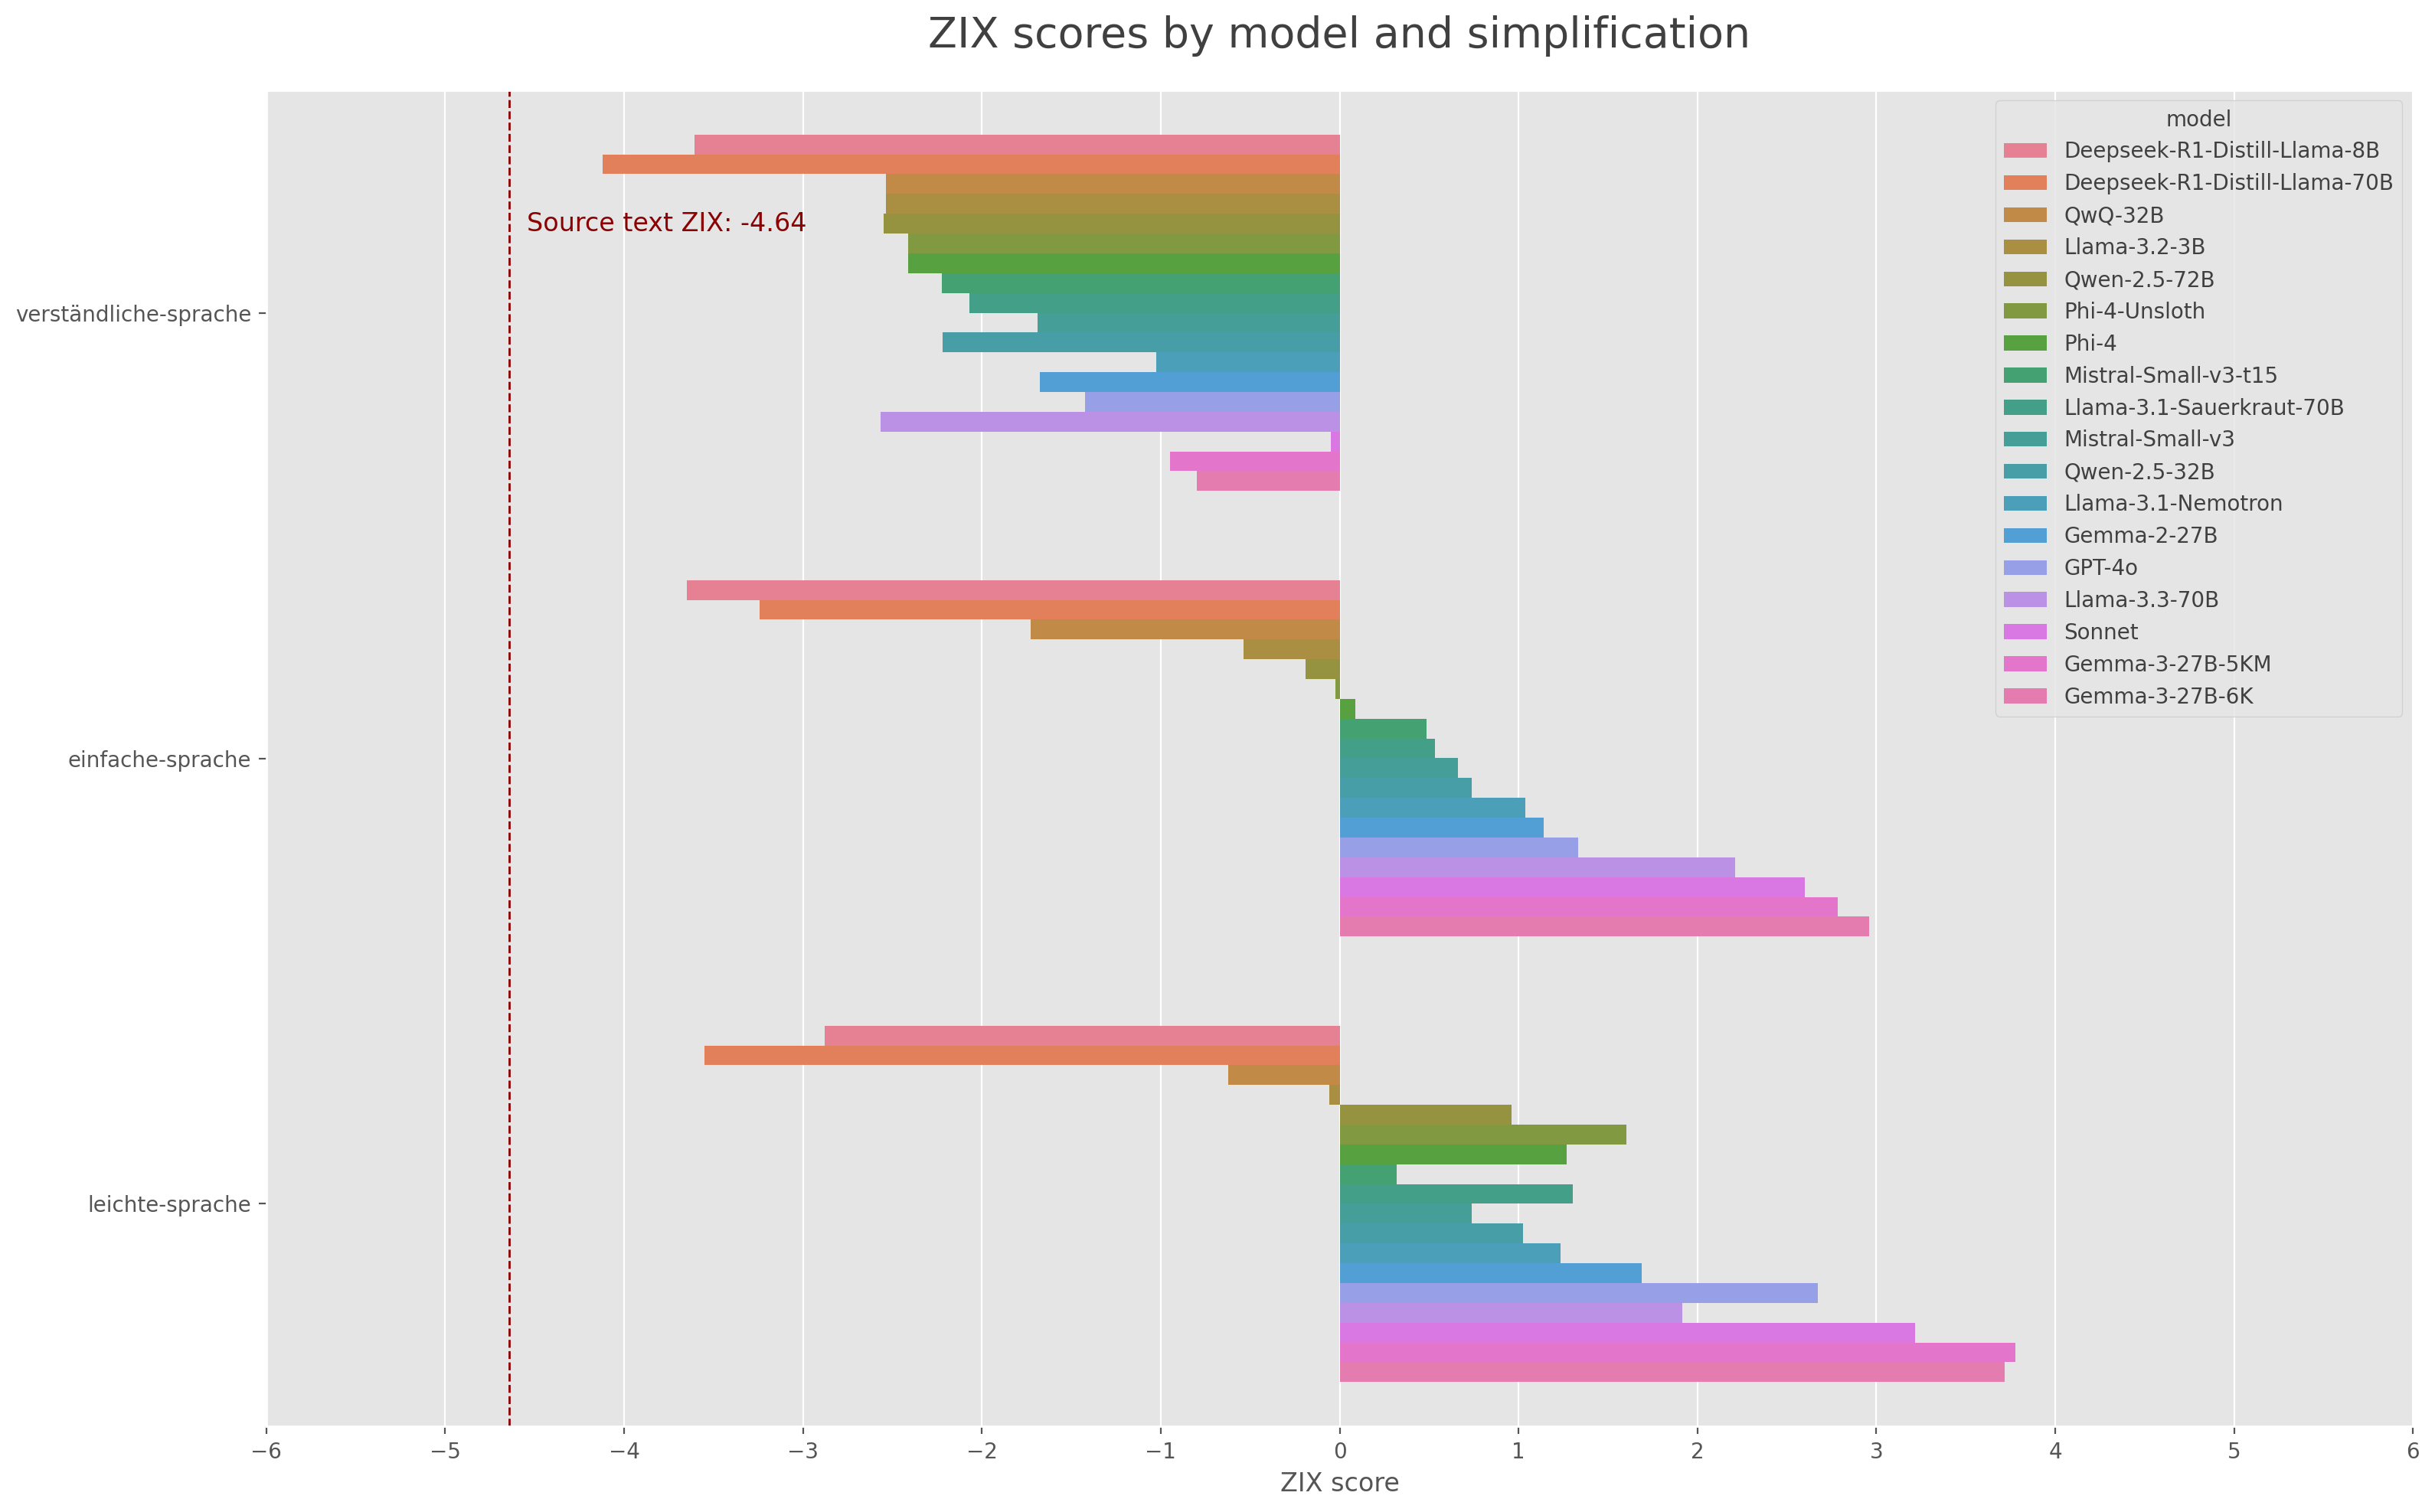

In [16]:
tmp = (
    df.groupby(["simplification", "model"])
    .result_zix.mean()
    .reset_index()
    .sort_values(by=["simplification", "result_zix"], ascending=True)
)

source_text_mean = df.source_zix.mean()

order = [
    "verständliche-sprache",
    "einfache-sprache",
    "leichte-sprache",
]
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(
    data=tmp,
    y="simplification",
    x="result_zix",
    hue="model",
    ax=ax,
    order=order,
)
ax.set_title("ZIX scores by model and simplification", fontsize=20, pad=20)
ax.set_xlabel("ZIX score")
ax.set_ylabel(None)
ax.set_xlim(-6, 6)
ax.set_xticks(np.arange(-6, 7, 1))

ax.axvline(source_text_mean, color="darkred", linestyle="--", linewidth=1)
ax.text(
    source_text_mean + 0.1,
    -0.2,
    f"Source text ZIX: {source_text_mean:.2f}",
    color="darkred",
    fontsize=12,
    verticalalignment="center",
)

plt.tight_layout()
plt.show()

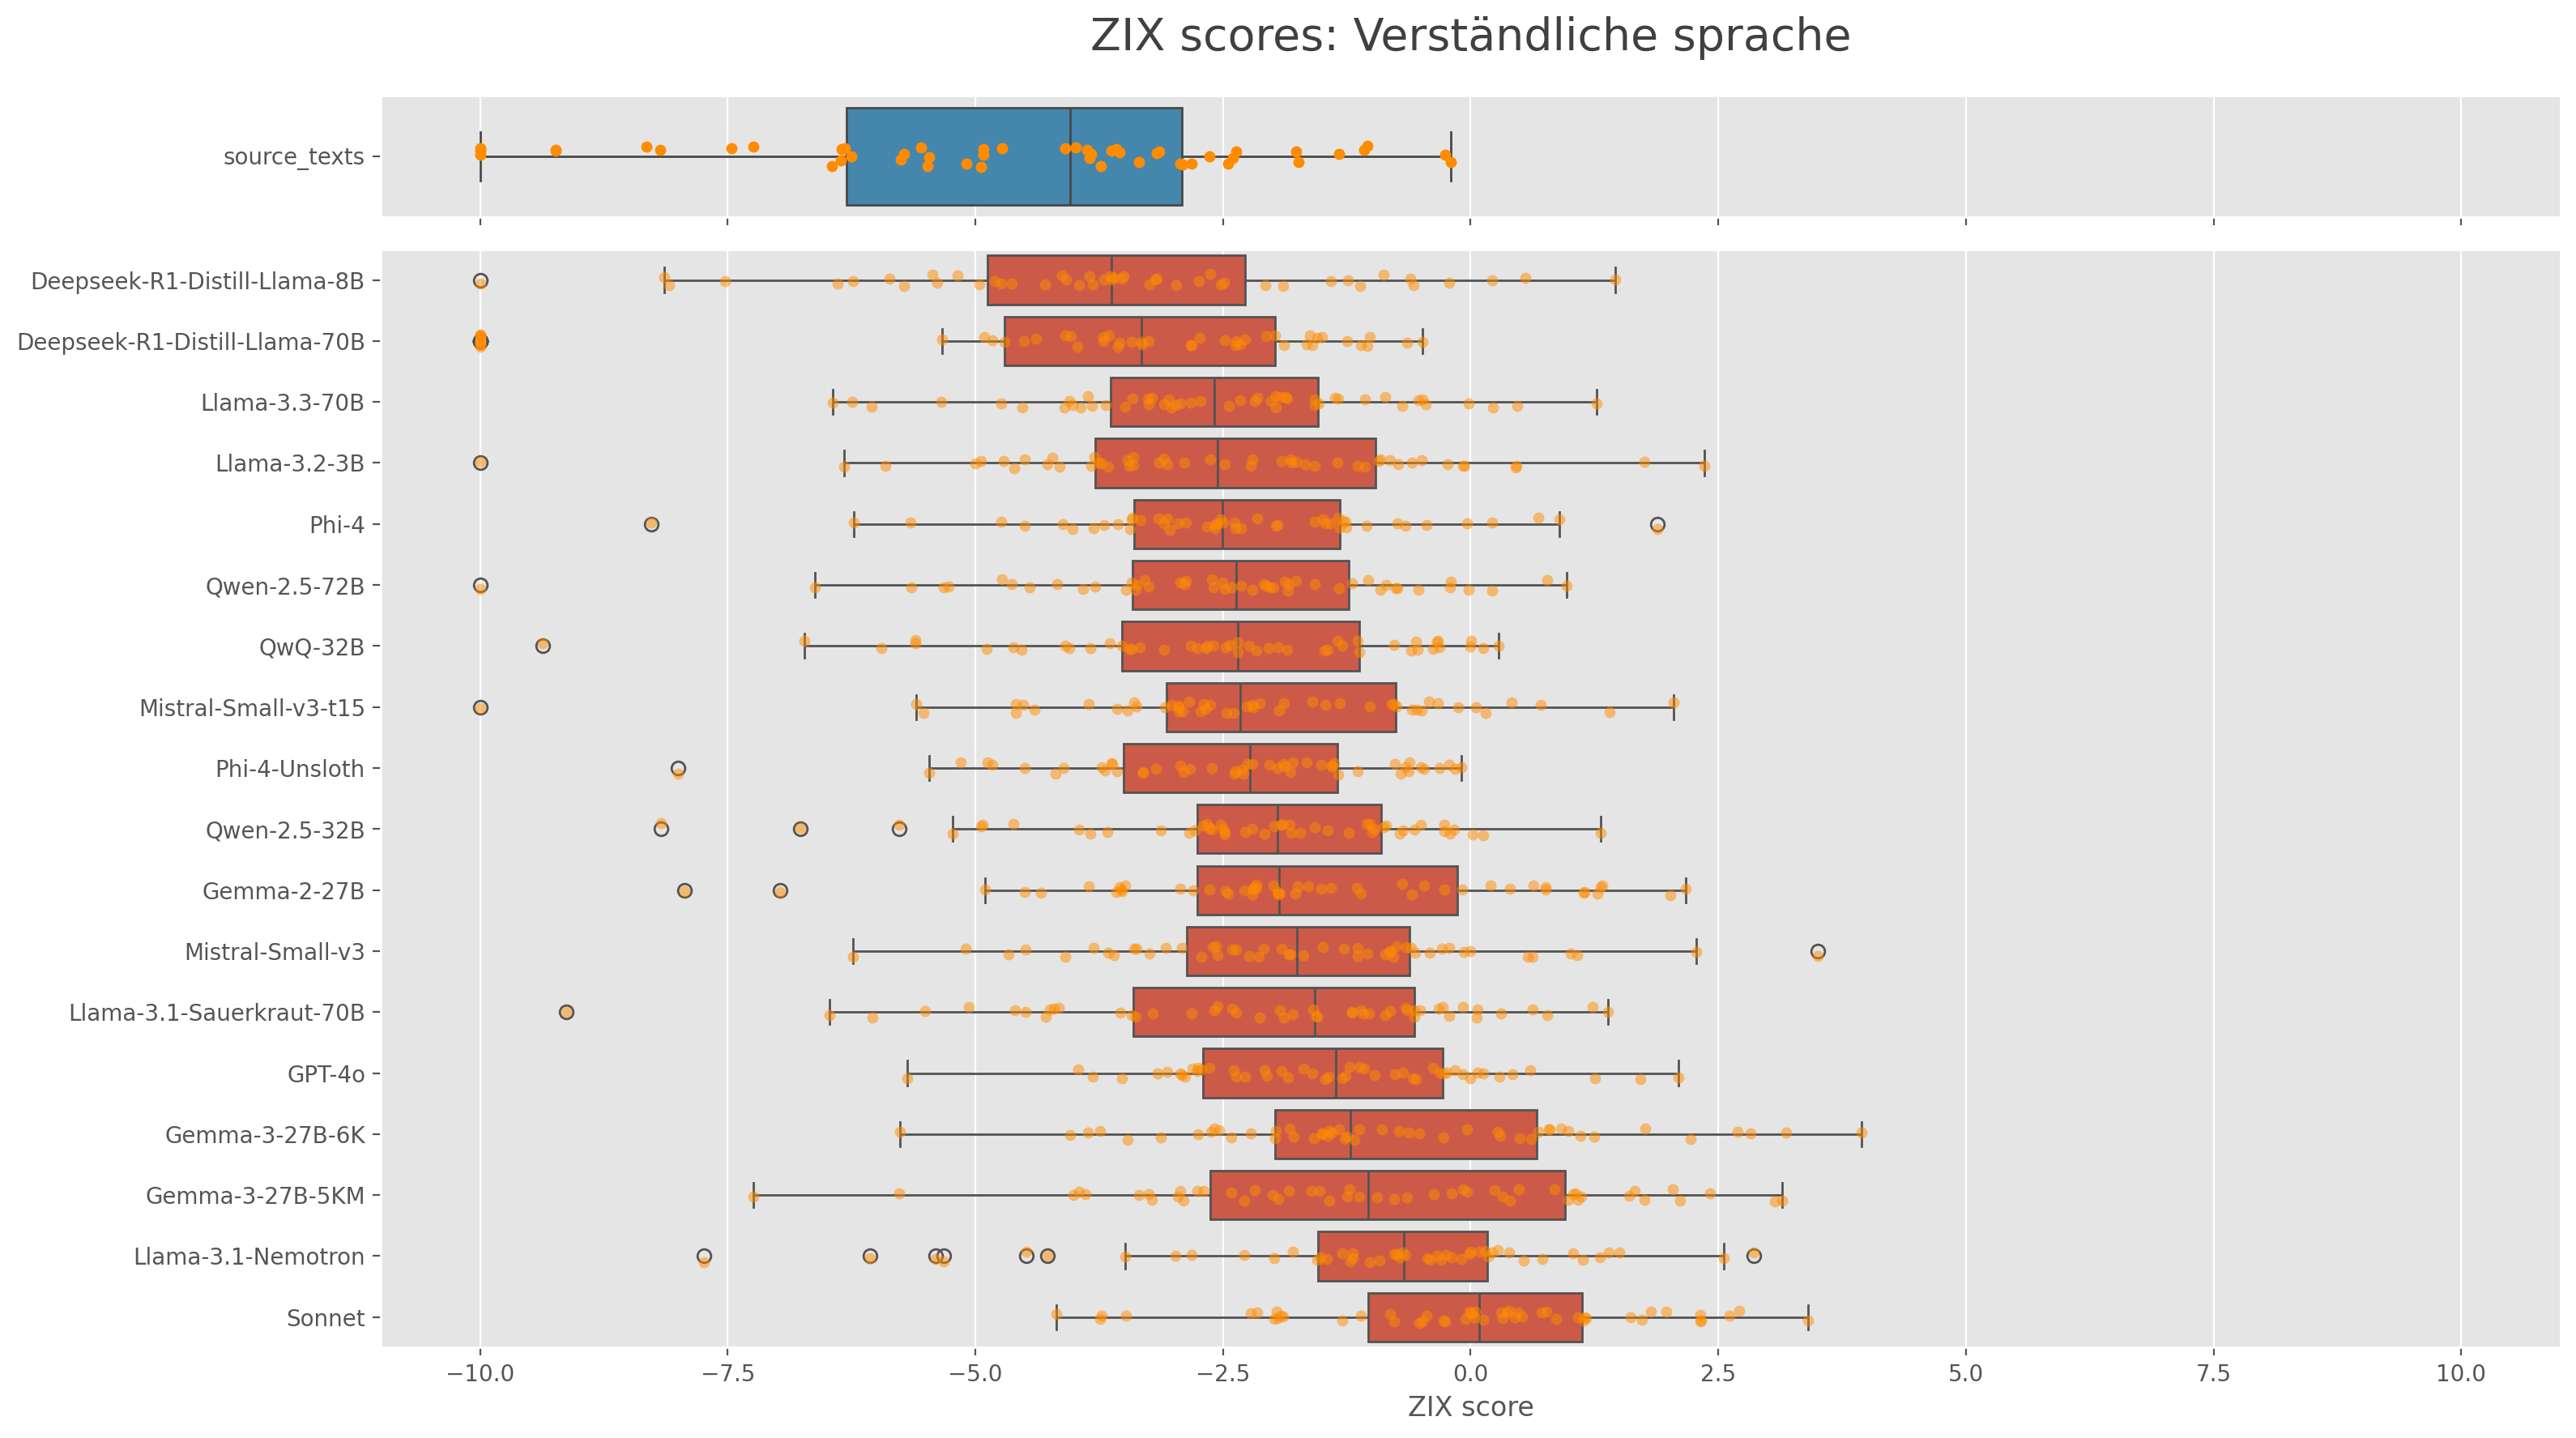

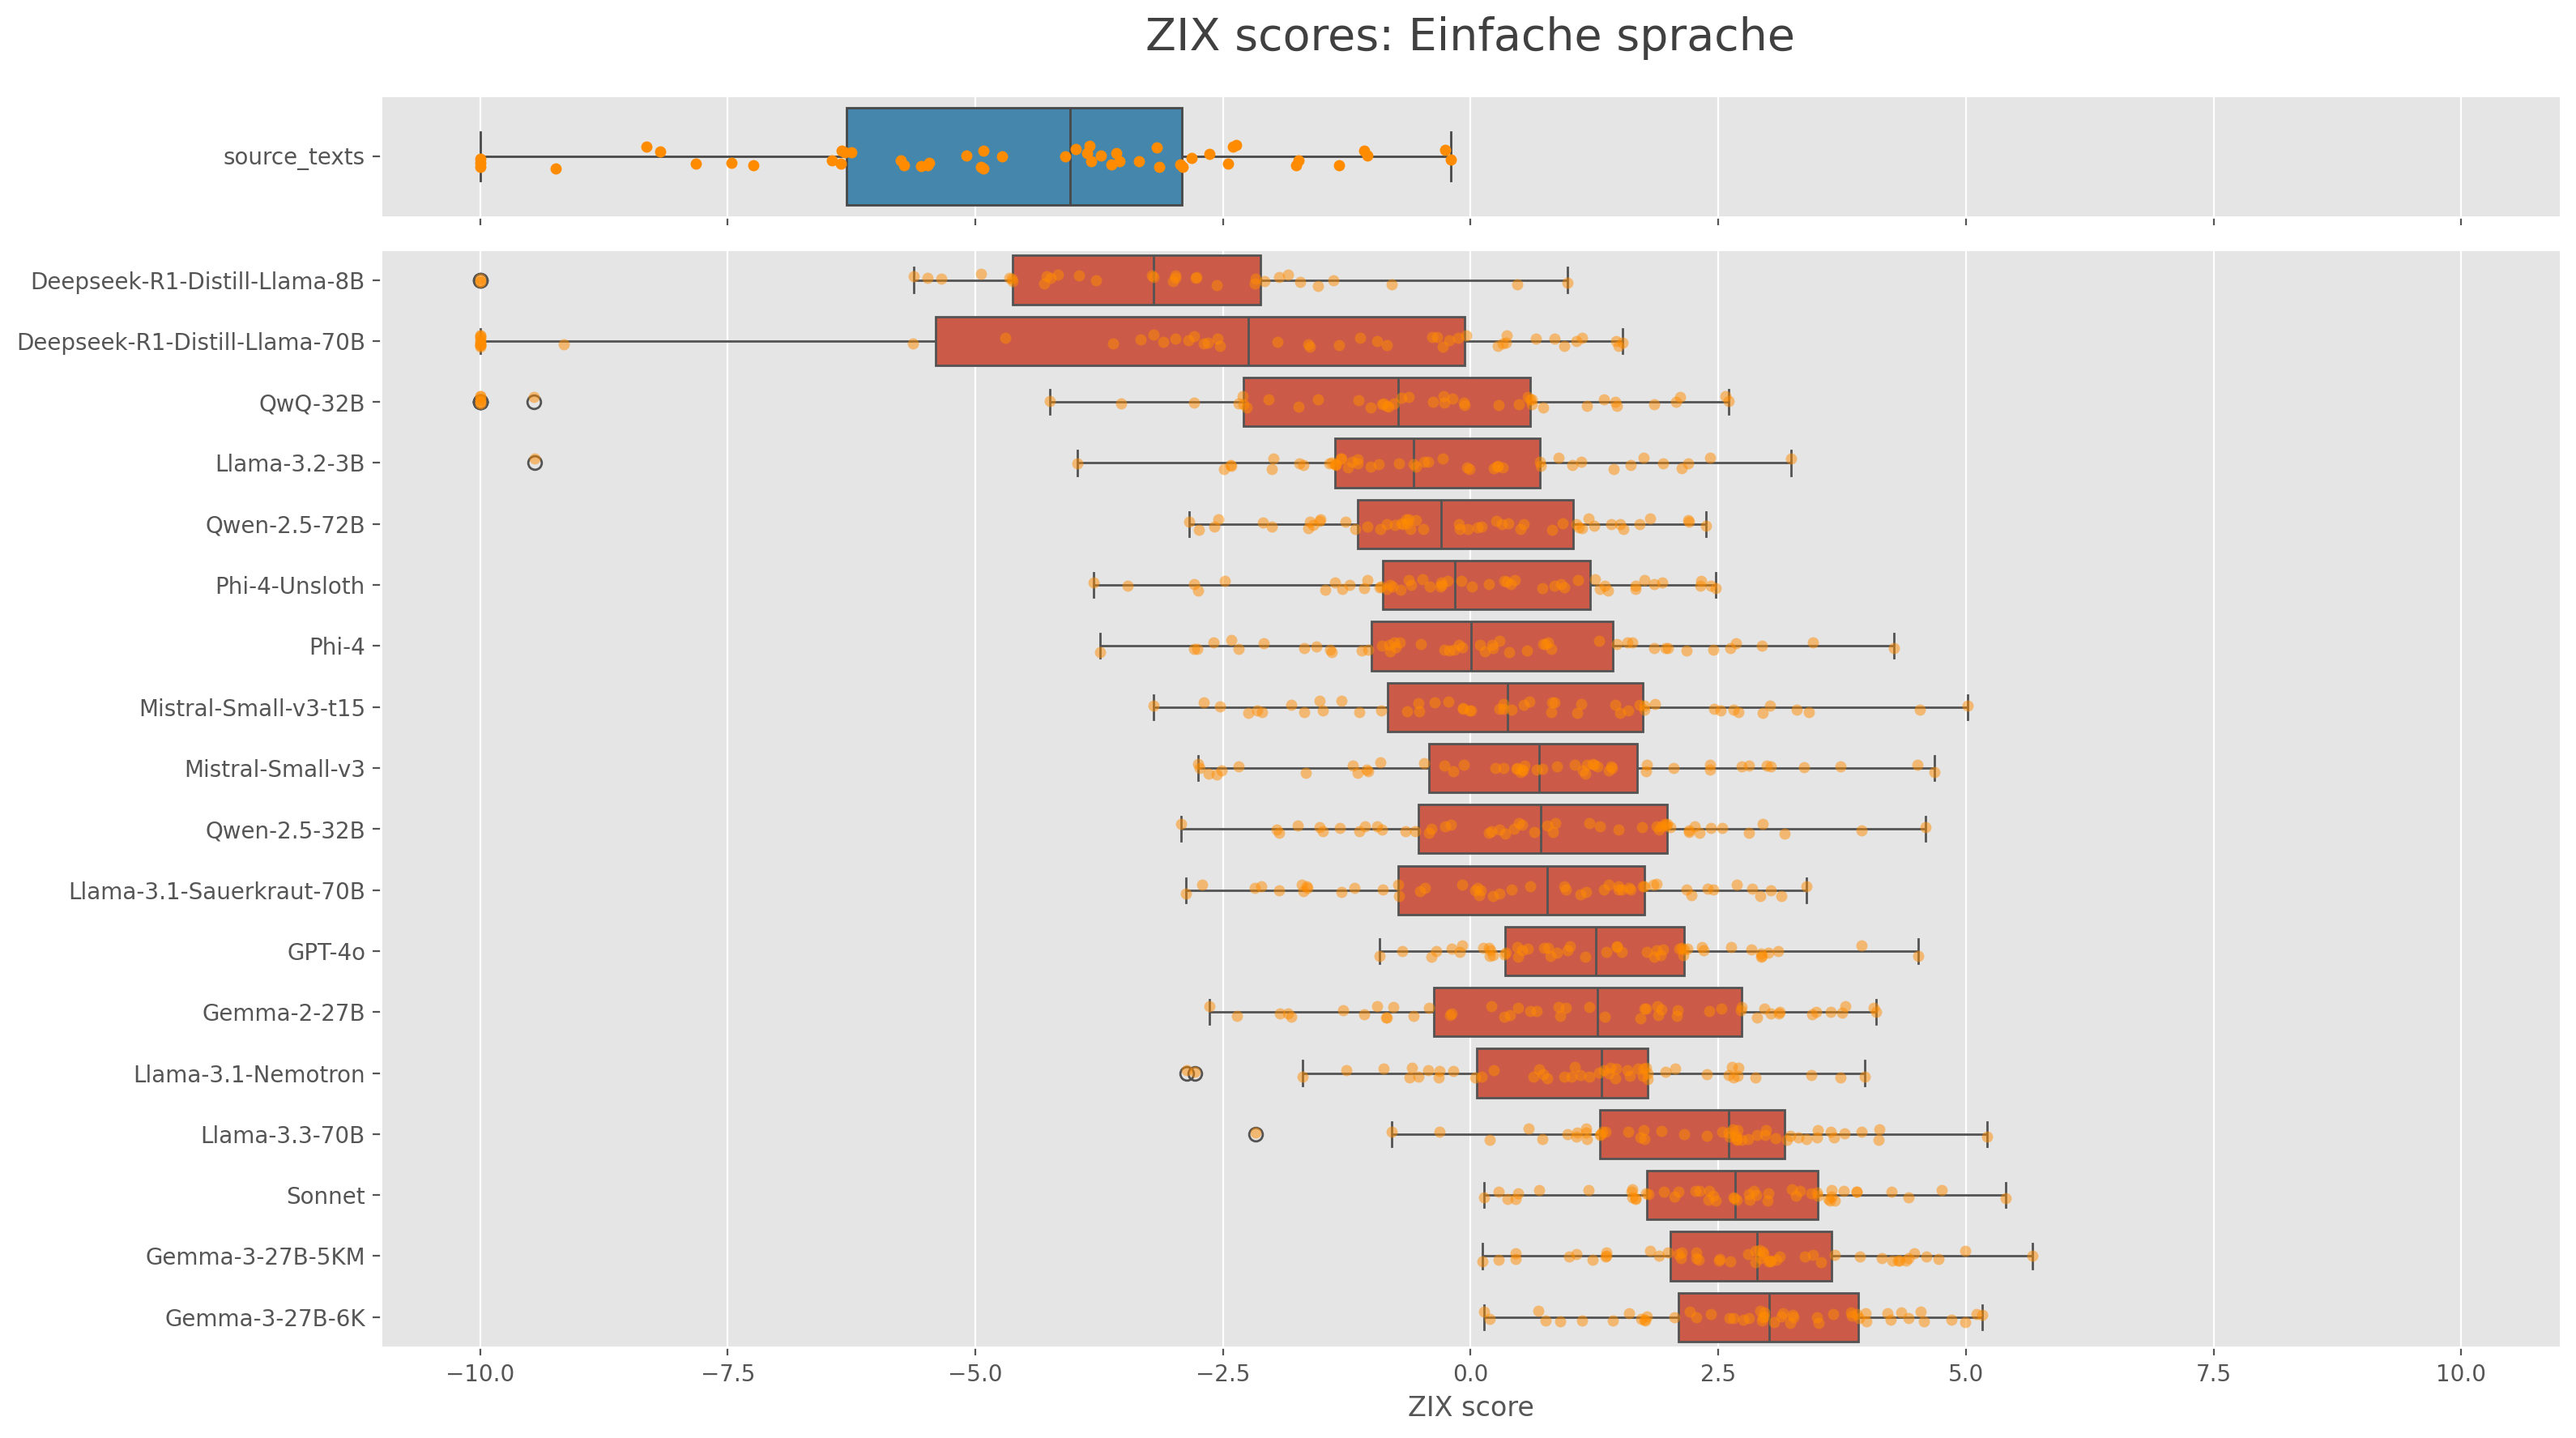

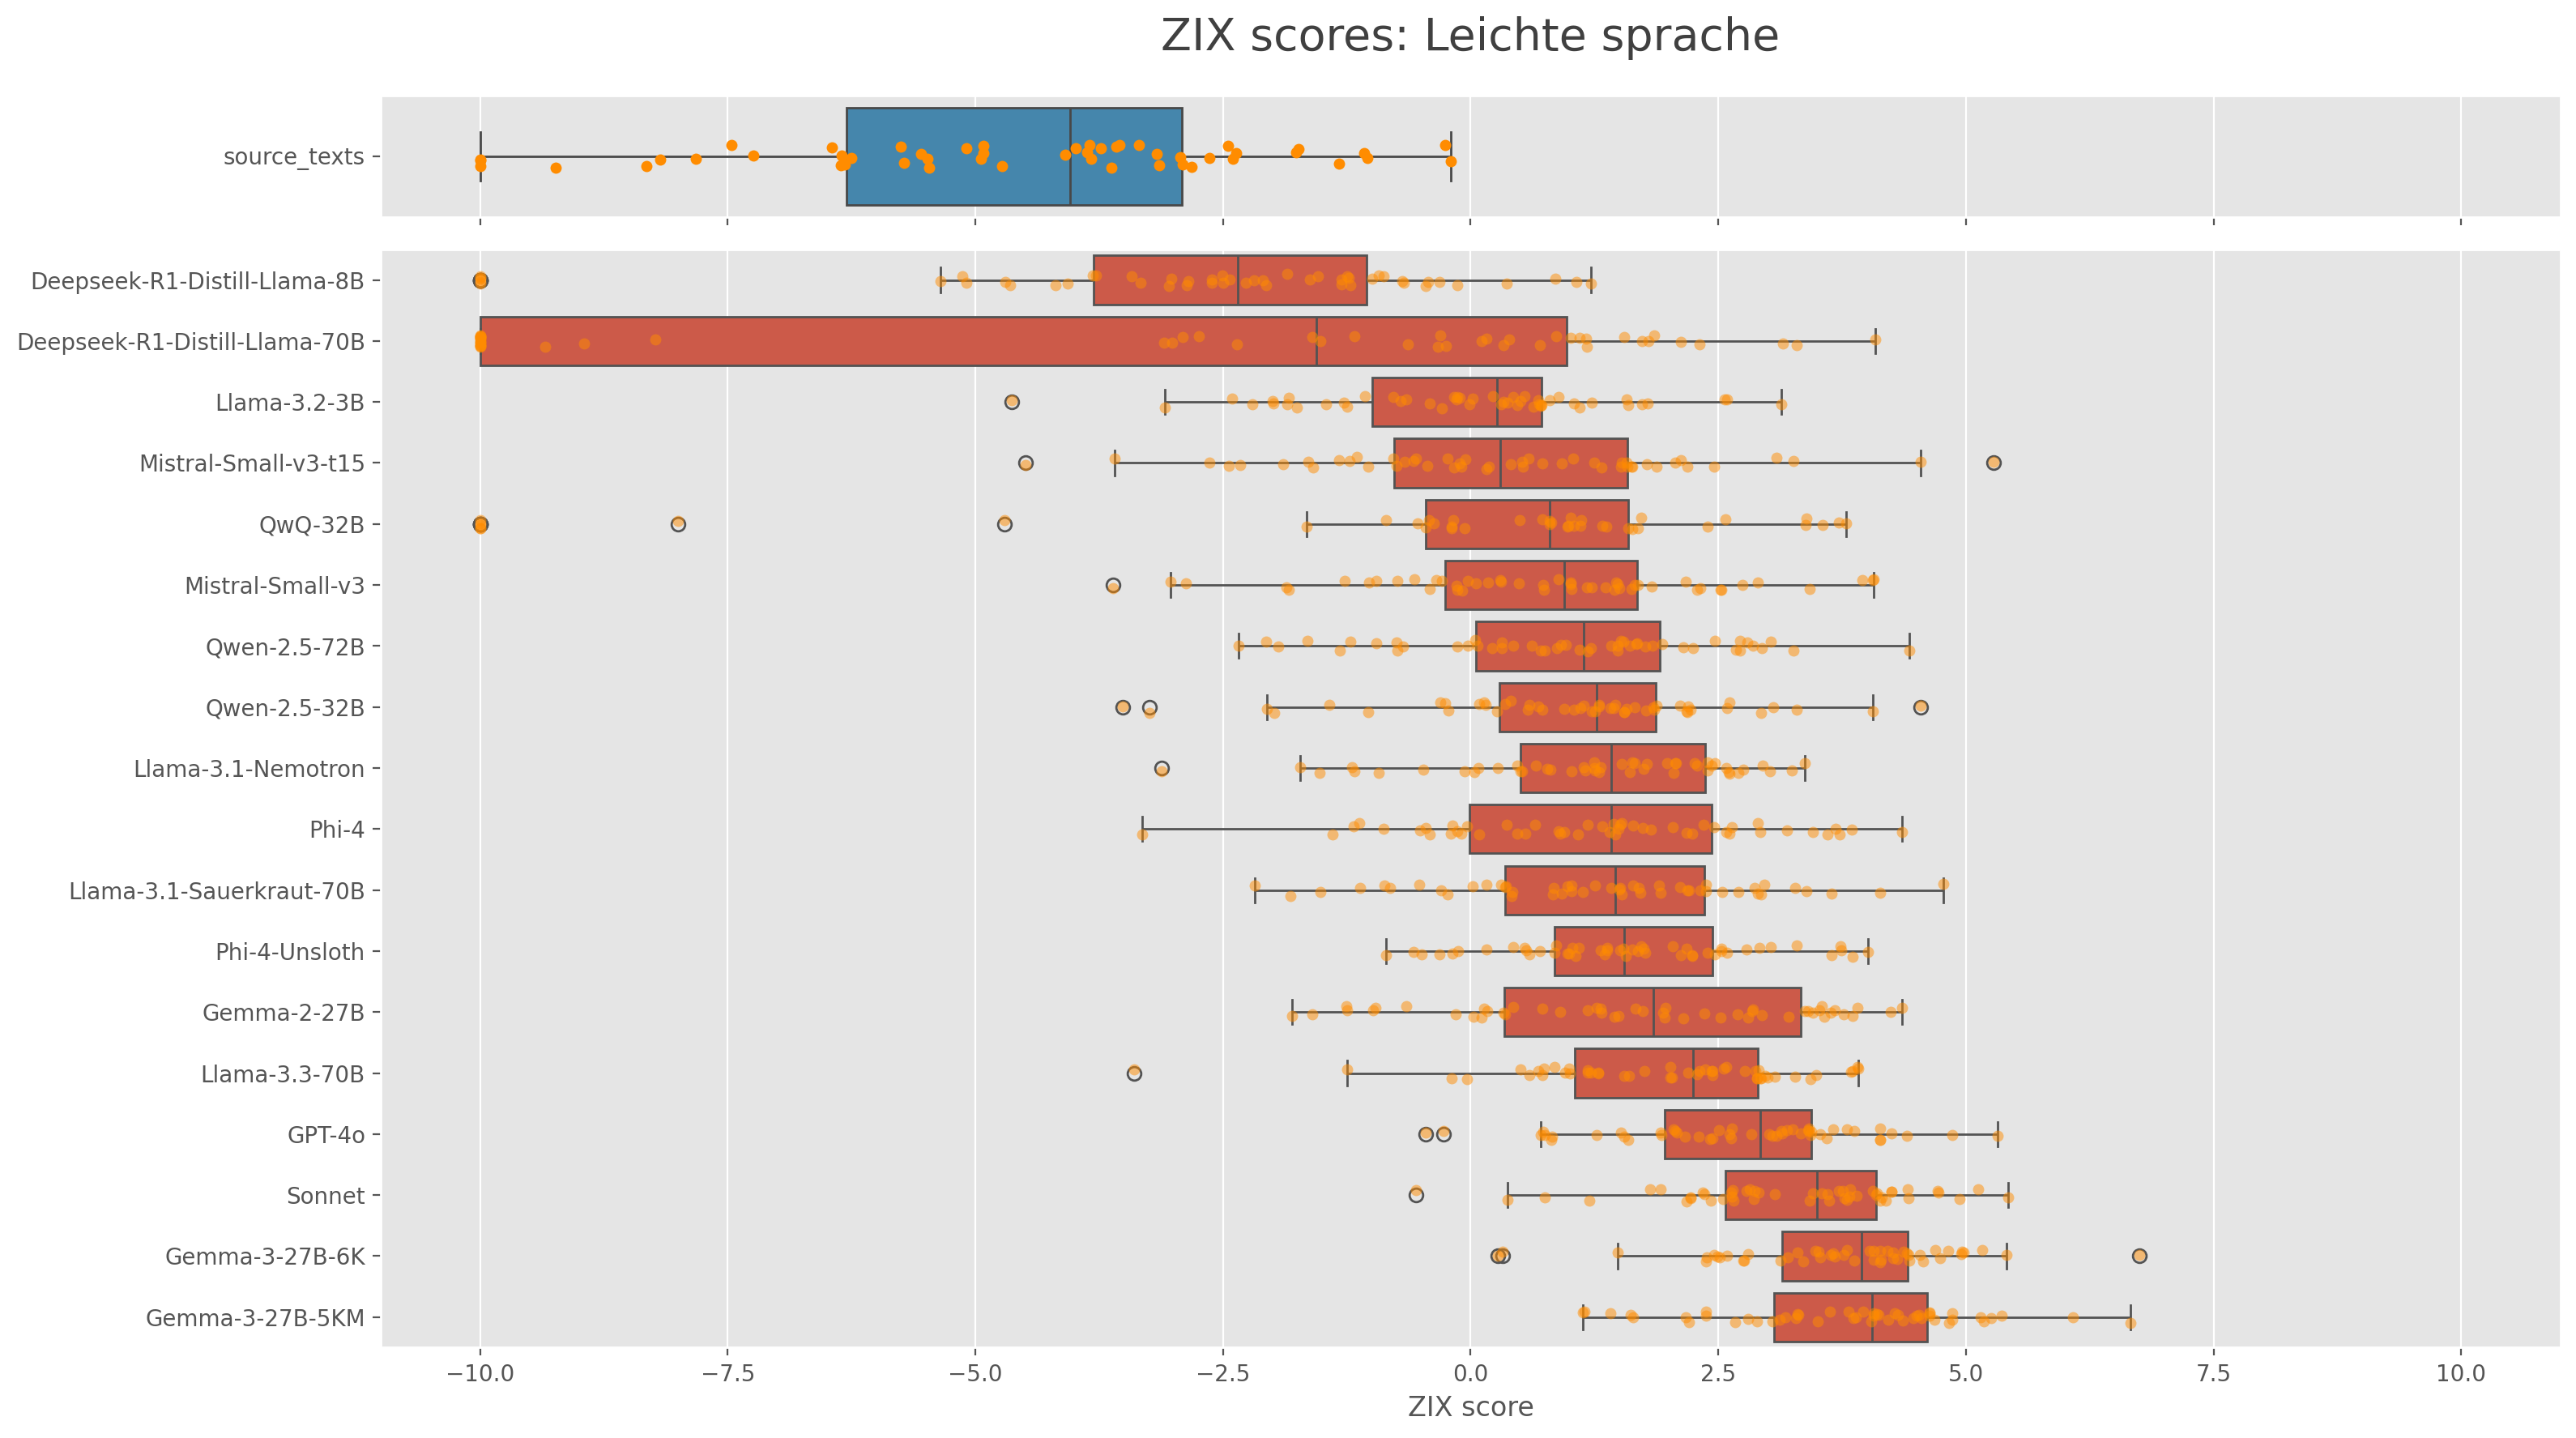

In [17]:
for simplification in [
    "verständliche-sprache",
    "einfache-sprache",
    "leichte-sprache",
]:
    subset = df[df.simplification == simplification]

    fig, ax = plt.subplots(
        2, 1, figsize=(16, 9), gridspec_kw={"height_ratios": [1, 9]}, sharex=True
    )
    tmp = subset.iloc[:50]
    sns.boxplot(
        data=tmp,
        y=["source_texts"] * len(tmp),
        x="source_zix",
        ax=ax[0],
        color=DEFAULT_COLORS[1],
    )
    sns.stripplot(
        data=tmp,
        x="source_zix",
        y=["source_texts"] * len(tmp),
        ax=ax[0],
        color="darkorange",
    )

    ax[0].set_title(
        f"ZIX scores: {simplification.replace('-', ' ').capitalize()}",
        fontsize=20,
        pad=20,
    )
    order = subset.groupby("model").result_zix.median().sort_values().index
    sns.boxplot(
        data=subset,
        y="model",
        x="result_zix",
        ax=ax[1],
        order=order,
    )
    sns.stripplot(
        data=subset,
        y="model",
        x="result_zix",
        ax=ax[1],
        order=order,
        color="darkorange",
        alpha=0.5,
    )

    ax[1].set_xlabel("ZIX score")
    ax[1].set_ylabel(None)
    ax[1].set_xlim(-11, 11)

    plt.tight_layout()
    plt.show()

### Judge simplificiations

In [18]:
tag_scratchpad = "scratchpad"
tag_answer = "answer"


def get_result_from_llm_evals(response):
    """Extract text between tags from response."""
    if response is None:
        return None
    scratchpad = re.findall(
        rf"<{tag_scratchpad}>(.*?)</{tag_scratchpad}>", response, re.DOTALL
    )
    answer = re.findall(rf"<{tag_answer}>(.*?)</{tag_answer}>", response, re.DOTALL)
    if len(answer) == 0 or len(scratchpad) == 0:
        return "", ""
    return scratchpad[0], answer[0]


def process_evals(results):
    results = [get_result_from_llm_evals(result) for result in results]
    results = [(result[0].strip(), result[1].strip()) for result in results]
    return pd.DataFrame(results, columns=["scratchpad", "answer"])

In [19]:
df.model.unique()

array(['Deepseek-R1-Distill-Llama-70B', 'Deepseek-R1-Distill-Llama-8B',
       'GPT-4o', 'Gemma-2-27B', 'Gemma-3-27B-5KM', 'Gemma-3-27B-6K',
       'Llama-3.1-Nemotron', 'Llama-3.1-Sauerkraut-70B', 'Llama-3.2-3B',
       'Llama-3.3-70B', 'Mistral-Small-v3-t15', 'Mistral-Small-v3',
       'Phi-4-Unsloth', 'Phi-4', 'QwQ-32B', 'Qwen-2.5-32B',
       'Qwen-2.5-72B', 'Sonnet'], dtype=object)

In [ ]:
results = []
chunk_size = 100
for chunk in range(0, len(df), chunk_size):
    print(f"Processing chunk {chunk} to {chunk + chunk_size}")
    tmp = df.iloc[chunk : chunk + chunk_size].copy(deep=True)
    tmp.reset_index(drop=True, inplace=True)
    prompts = []
    for idx, d in tmp.iterrows():
        prompts.append(
            EVAL_PROMPT_01.format(original=d.source, einfacheversion=d.result)
        )
    args = [(prompt, GPT4o, TEMPERATURE_EVAL) for prompt in prompts]
    with ThreadPoolExecutor(max_workers=20) as executor:
        raw_results = list(executor.map(call_openai, *zip(*args)))
    evals = process_evals(raw_results)
    evals = pd.concat([tmp, evals], axis=1)
    results.append(evals)
    evals.to_parquet(f"{DATA_DIR}eval_gpt_{chunk}.parq")

finals = pd.concat(results)
finals.to_parquet(f"{DATA_DIR}eval_gpt_all.parq")
finals.to_excel(f"{DATA_DIR}eval_gpt_all.xlsx", index=False)

Evaluate additional simplifications from proprietary models.

In [20]:
# # Addional models 01.
# additional_models = ["GPT-4o", "Sonnet", "Mistral-Small-v3"]

# Additional models 02.
additional_models = ["Gemma-3-27B-5KM", "Gemma-3-27B-6K"]

results = []
chunk_size = 100
for chunk in range(0, len(df[df.model.isin(additional_models)]), chunk_size):
    print(f"Processing chunk {chunk} to {chunk + chunk_size}")
    tmp = (
        df[df.model.isin(additional_models)]
        .iloc[chunk : chunk + chunk_size]
        .copy(deep=True)
    )
    tmp.reset_index(drop=True, inplace=True)
    prompts = []
    for idx, d in tmp.iterrows():
        prompts.append(
            EVAL_PROMPT_01.format(original=d.source, einfacheversion=d.result)
        )
    args = [(prompt, GPT4o, TEMPERATURE_EVAL) for prompt in prompts]
    with ThreadPoolExecutor(max_workers=20) as executor:
        raw_results = list(executor.map(call_openai, *zip(*args)))
    evals = process_evals(raw_results)
    evals = pd.concat([tmp, evals], axis=1)
    results.append(evals)
    evals.to_parquet(f"{DATA_DIR}eval_gpt_additional_tmp_{chunk}.parq")

finals = pd.concat(results)
finals.to_parquet(f"{DATA_DIR}eval_gpt_additional_02.parq")
finals.to_excel(f"{DATA_DIR}eval_gpt_additional_02.xlsx", index=False)

Processing chunk 0 to 100
Processing chunk 100 to 200
Processing chunk 200 to 300


### Check evals

In [21]:
gpt = pd.read_parquet(f"{DATA_DIR}eval_gpt_all.parq")
add_01 = pd.read_parquet(f"{DATA_DIR}eval_gpt_additional_01.parq")
add_02 = pd.read_parquet(f"{DATA_DIR}eval_gpt_additional_02.parq")
gpt = pd.concat([gpt, add_01, add_02])
gpt.sort_values(["result", "model"], ascending=False, inplace=True)
gpt.reset_index(drop=True, inplace=True)
gpt.replace("Pass", True, inplace=True)
gpt.replace("Fail", False, inplace=True)
to_replace = gpt[gpt.answer == "Unsure"].index
gpt.loc[to_replace, "answer"] = True
to_replace = gpt[gpt.answer == ""].index
gpt.loc[to_replace, "answer"] = True

In [22]:
selection = [
    "Llama-3.1-Nemotron",
    "Qwen-2.5-32B",
    "Qwen-2.5-72B",
    "Llama-3.3-70B",
    "Llama-3.1-Sauerkraut-70B",
    "Phi-4",
    "Phi-4-Unsloth",
    "Gemma-2-27B",
    "Gemma-3-27B-5KM",
    "Gemma-3-27B-6K",
    "GPT-4o",
    "Sonnet",
    "Mistral-Small-v3",
]

In [23]:
total_accuracy = np.round(gpt[gpt.model.isin(selection)].answer.mean(), 4) * 100
print(f"Total accuracy: {total_accuracy:.02f}%")

Total accuracy: 86.92%


In [24]:
display(gpt.groupby("model").answer.mean().sort_values(ascending=False))
print(np.round(gpt.groupby("model").answer.mean().min(), 2))
print(np.round(gpt.groupby("model").answer.mean().max(), 2))

model
Llama-3.1-Nemotron                   0.96
Qwen-2.5-72B                     0.913333
Phi-4                                 0.9
Phi-4-Unsloth                         0.9
Sonnet                                0.9
Deepseek-R1-Distill-Llama-70B    0.892617
Gemma-2-27B                      0.873333
Gemma-3-27B-6K                   0.866667
GPT-4o                           0.863309
Llama-3.1-Sauerkraut-70B             0.86
Llama-3.3-70B                    0.826667
Mistral-Small-v3                     0.81
Qwen-2.5-32B                     0.806667
Gemma-3-27B-5KM                       0.8
Deepseek-R1-Distill-Llama-8B     0.590909
Llama-3.2-3B                     0.408163
Name: answer, dtype: object

0.41
0.96


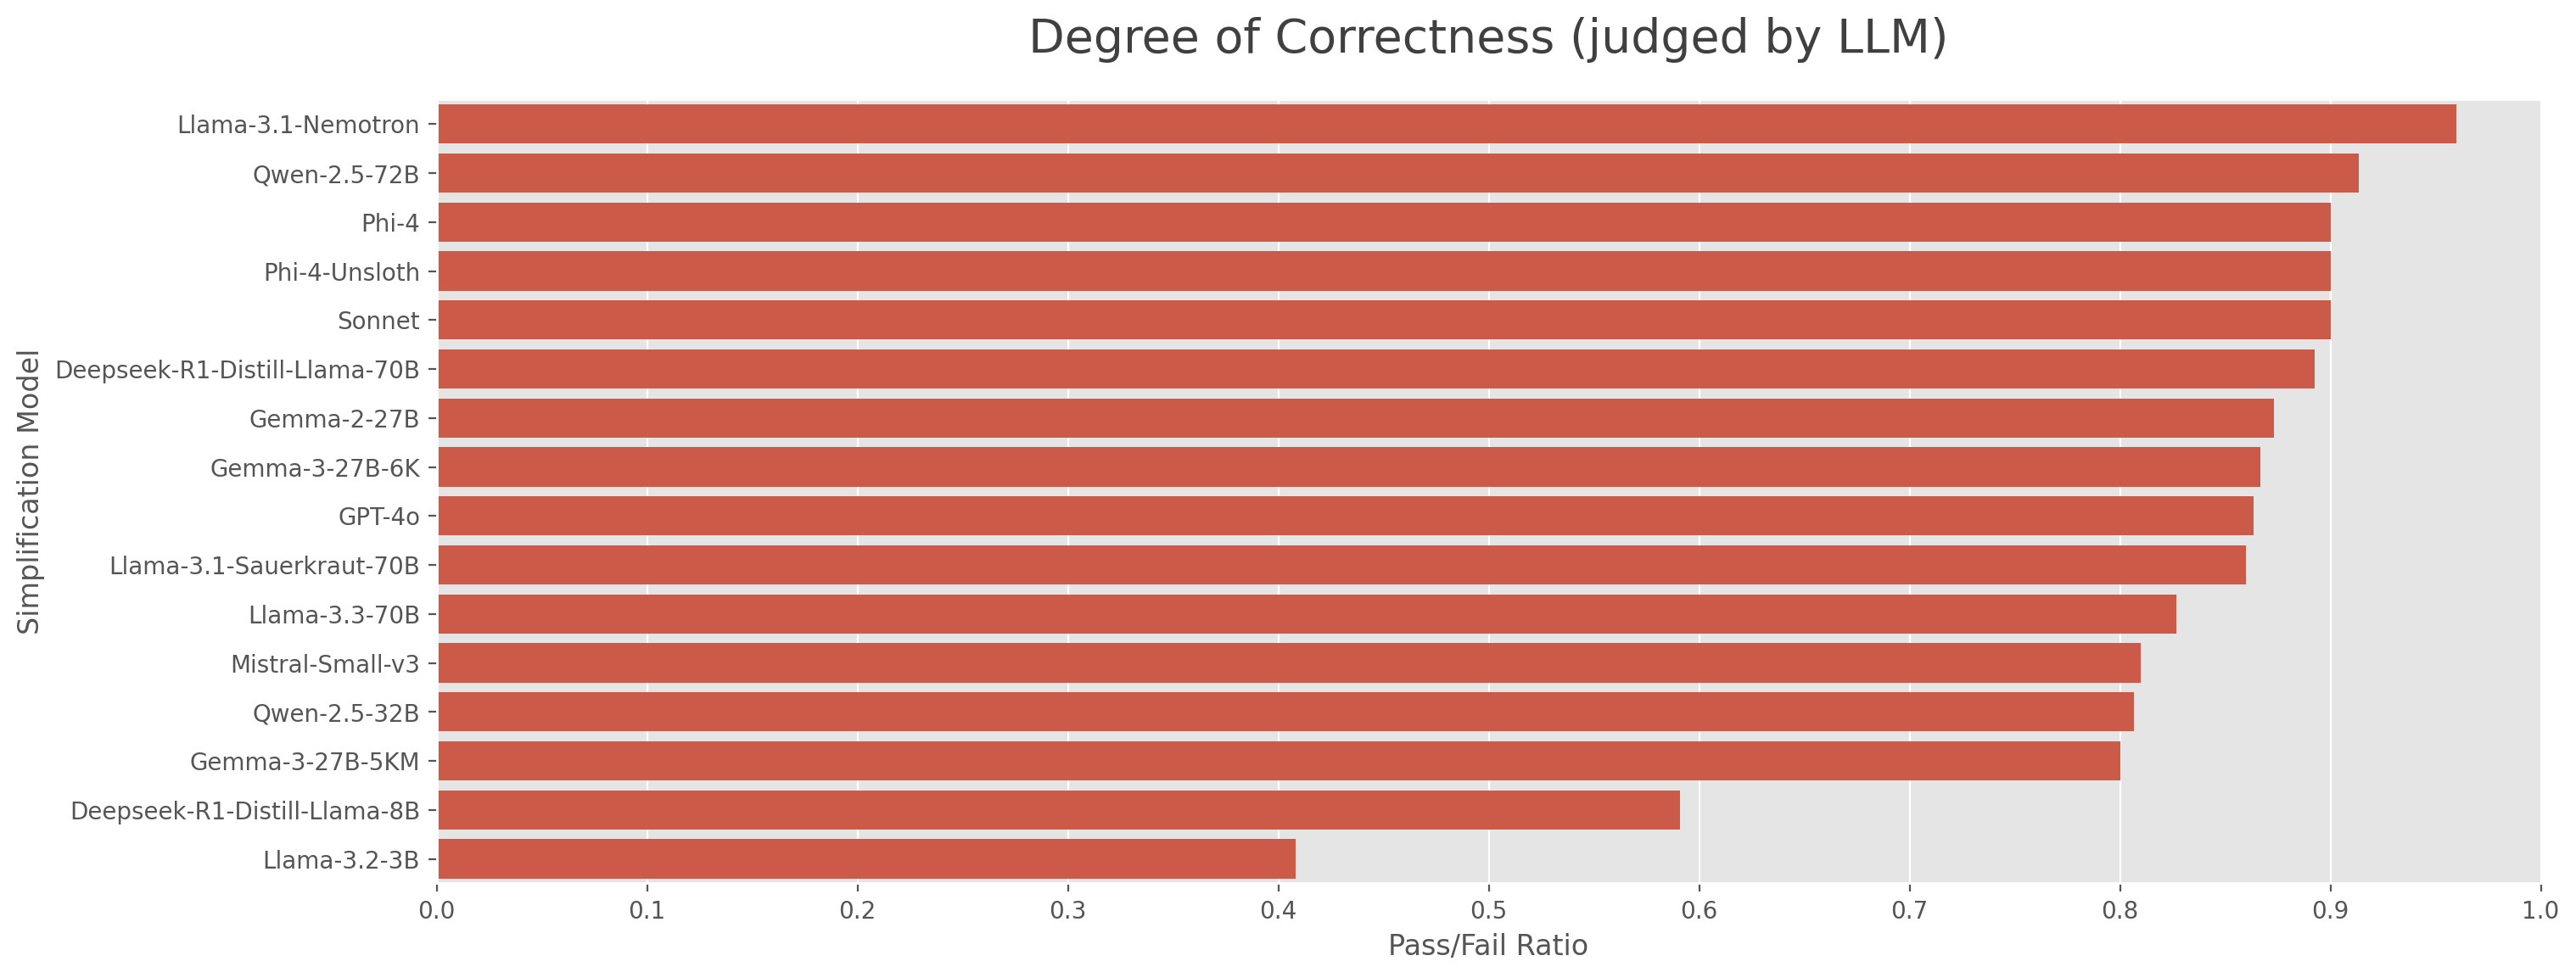

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

tmp = gpt.groupby("model").answer.mean().reset_index()
tmp.sort_values(["answer"], ascending=False, inplace=True)
tmp.reset_index(drop=True, inplace=True)

sns.barplot(
    data=tmp,
    y="model",
    x="answer",
    ax=ax,
    errorbar=None,
)

ax.set_title("Degree of Correctness (judged by LLM)", fontsize=20, pad=20)
ax.set_ylabel("Simplification Model")
ax.set_xlabel("Pass/Fail Ratio")
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim(0, 1)
plt.show()